# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: October, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [1]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9MB 7.8MB/s 


# **Imports and Configuration**

In [66]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import math

In [3]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#map_location=torch.device('cpu')
#please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
#torch.load(map_location)

cuda


In [5]:
# Configure Tensorboard
%load_ext tensorboard

In [6]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [7]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2021-05-20 10:32:11--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2021-05-20 10:32:11--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1074aeb74adcd6e8ade5a87856.dl.dropboxusercontent.com/cd/0/inline/BO2ZX6r_xWOJd8L5qrklJA_RH3Sfkps5CNZso2Qh9A12WpMR8bpjq_oTElrjN5OYfDFXM_2Vyv4DStiyuENQgmSh6s2pGF2wxD4U5jt8-BUc-C3Cawyv0R116tkJn8T9Bnml1v1UHYBXT4fSjGReQSP3/file# [following]
--2021-05-20 10:32:12--  https://uc1074aeb74adcd6e8ade5a87856.dl.dropboxusercontent.com/cd/0/inline/BO2ZX6r_xWOJd8L5qrklJA_RH3Sfkps5CNZso2Qh9A12WpMR8bp

# **Extract .zip**

In [8]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [9]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 2222, done.
remote: Total 2222 (delta 0), reused 0 (delta 0), pack-reused 2222
Receiving objects: 100% (2222/2222), 1.93 GiB | 40.58 MiB/s, done.
Resolving deltas: 100% (1295/1295), done.
Checking out files: 100% (361/361), done.


In [10]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [11]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))

20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin


# **Create PyTorch Datasets for Training and Testing**

In [12]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [13]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [14]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [15]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [16]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

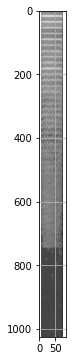

In [17]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

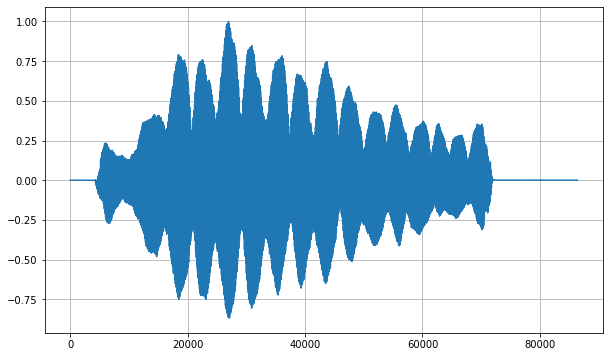

In [18]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [19]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file

# **Visualising tensorboard data from runs.zip**

In [20]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_100.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_100.zip
   creating: runs/content/runs/
   creating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/
   creating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Classification Accuracy_Test Classification/events.out.tfevents.1609332555.d0956b6b0bf2.61.8  
   creating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Losses_Test Total Loss/
  inflating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Losses_Test Total Loss/events.out.tfevents.1609332555.d0956b6b0bf2.61.6  
   creating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Classification Accuracy_Train Classification /
  inflating: runs/content/runs/Dec30_12-46-00_d0956b6b0bf2/Classification Accuracy_Train Classification /events.out.tfevents.1609332555.d0956b6b0bf2.61.7  
  inflating: runs/content/runs/Dec30_12-46-00_d0

In [21]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_200.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_200.zip
   creating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/
   creating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Classification Accuracy_Test Classification/events.out.tfevents.1609418432.8dd00c409e83.58.8  
   creating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Losses_Test Total Loss/
  inflating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Losses_Test Total Loss/events.out.tfevents.1609418432.8dd00c409e83.58.6  
  inflating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/events.out.tfevents.1609417915.8dd00c409e83.58.0  
   creating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Classification Accuracy_Train Classification /
  inflating: runs/content/runs/Dec31_12-31-52_8dd00c409e83/Classification Accuracy_Train Classification /events.out.tfevents.1

In [22]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_300.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_300.zip
   creating: runs/content/runs/Dec31_20-13-06_670b72240312/
  inflating: runs/content/runs/Dec31_20-13-06_670b72240312/events.out.tfevents.1609445589.670b72240312.56.0  
   creating: runs/content/runs/Dec31_20-13-06_670b72240312/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Dec31_20-13-06_670b72240312/Classification Accuracy_Test Classification/events.out.tfevents.1609445835.670b72240312.56.8  
   creating: runs/content/runs/Dec31_20-13-06_670b72240312/Losses_Test Total Loss/
  inflating: runs/content/runs/Dec31_20-13-06_670b72240312/Losses_Test Total Loss/events.out.tfevents.1609445835.670b72240312.56.6  
   creating: runs/content/runs/Dec31_20-13-06_670b72240312/Classification Accuracy_Train Classification /
  inflating: runs/content/runs/Dec31_20-13-06_670b72240312/Classification Accuracy_Train Classification /events.out.tfevents.1

In [23]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_400.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_400.zip
   creating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/
   creating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Classification Accuracy_Test Classification/events.out.tfevents.1609504799.ce1b5c5e2f1a.57.8  
   creating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Losses_Test Total Loss/
  inflating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Losses_Test Total Loss/events.out.tfevents.1609504799.ce1b5c5e2f1a.57.6  
  inflating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/events.out.tfevents.1609504539.ce1b5c5e2f1a.57.0  
   creating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Classification Accuracy_Train Classification /
  inflating: runs/content/runs/Jan01_12-35-36_ce1b5c5e2f1a/Classification Accuracy_Train Classification /events.out.tfevents.1

In [24]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_500.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_500.zip
   creating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/
   creating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/Classification Accuracy_Test Classification/events.out.tfevents.1609600929.3b08b56e4dc0.57.9  
   creating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/Losses_Test Total Loss/
  inflating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/Losses_Test Total Loss/events.out.tfevents.1609600929.3b08b56e4dc0.57.7  
  inflating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/events.out.tfevents.1609600929.3b08b56e4dc0.57.1  
  inflating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/events.out.tfevents.1609600692.3b08b56e4dc0.57.0  
   creating: runs/content/runs/Jan02_15-18-09_3b08b56e4dc0/Classification Accuracy_Train Classification /
  inflating: run

In [25]:
!unzip /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_600.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_600.zip
   creating: runs/content/runs/Apr07_15-08-25_c5358462c051/
   creating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Total Loss/
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Total Loss/events.out.tfevents.1617808345.c5358462c051.58.6  
   creating: runs/content/runs/Apr07_15-08-25_c5358462c051/Classification Accuracy_Test Classification/
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Classification Accuracy_Test Classification/events.out.tfevents.1617808345.c5358462c051.58.8  
   creating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Decoder Loss*w/
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Decoder Loss*w/events.out.tfevents.1617808345.c5358462c051.58.4  
   creating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Train Decoder Loss*w/
  inflating: runs/content/runs

In [27]:
!unzip -o /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_700.zip -d runs

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/runs_700.zip
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Total Loss/events.out.tfevents.1617808345.c5358462c051.58.6  
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Total Loss/events.out.tfevents.1617823617.c5358462c051.58.15  
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Classification Accuracy_Test Classification/events.out.tfevents.1617808345.c5358462c051.58.8  
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Classification Accuracy_Test Classification/events.out.tfevents.1617823617.c5358462c051.58.17  
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Decoder Loss*w/events.out.tfevents.1617823617.c5358462c051.58.13  
  inflating: runs/content/runs/Apr07_15-08-25_c5358462c051/Losses_Test Decoder Loss*w/events.out.tfevents.1617808345.c5358462c051.58.4  
  inflating: runs/content

In [30]:
logs_base_dir = "/content/runs/content/runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [31]:
writer = SummaryWriter()
writer.flush()

In [ ]:
%tensorboard --logdir {logs_base_dir}

In [34]:
!unzip -o /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/best_checkpoints_614_seventh100iter.zip -d checkpoints

Archive:  /content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/best_checkpoints_614_seventh100iter.zip
  inflating: checkpoints/content/checkpoints/AutoencoderInstrumetClassif-614.pkl  


# **PyTorch Analysis Filter Bank / Encoder Model**

In [35]:
# Model Parameters
in_channels = 1
n_subbands = 1024
filter_length = 2048
downsampling = 1024
padding = filter_length//2

In [36]:
# Analysis Filter Bank / Encoder
class Encoder(torch.nn.Module):
  """ Convolutional Neural Network Analysis Filter Bank for Musical Instruments Classification

  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  def __init__(self, in_channels=1,n_subbands=1024,filter_length=2048,downsampling = 1024, padding=1024, bias=False):
    super(Encoder, self).__init__()
    # Parameters
    self.in_channels = in_channels
    self.n_subbands = n_subbands
    self.filter_length=filter_length
    self.downsampling=downsampling
    self.padding = padding
    self.bias = bias
    # Layers
    self.conv1 = torch.nn.Conv1d(in_channels=self.in_channels, out_channels=self.n_subbands, kernel_size=self.filter_length, 
                                 stride=self.downsampling, padding=self.padding, bias=self.bias)

  def forward(self, x):
    x = self.conv1(x)
    return x

# **Weights Initialization**

In [37]:
# Weights Initialization Function
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.ConvTranspose1d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

# **Testing Encoder before Training**

In [38]:
# Create Analysis Filter Bank model
analysisFB = Encoder(in_channels=in_channels,n_subbands=n_subbands,filter_length=filter_length,downsampling = downsampling, padding=padding)
# Initialize weights
analysisFB.apply(weights_init)
# Send to Device
analysisFB.to(device)

Encoder(
  (conv1): Conv1d(1, 1024, kernel_size=(2048,), stride=(1024,), padding=(1024,), bias=False)
)

# **PyTorch Synthesis Filter Bank / Decoder**

In [39]:
# Model Parameters
out_channels = 1
n_subbands = 1024
filter_length = 2048
upsampling = 1024
dilatation=1
padding = 1

In [42]:

# Decoder
class Decoder(torch.nn.Module):
  """ Convolutional Neural Network Analysis Filter Bank for Musical Instruments Classification

  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  def __init__(self, n_subbands=1024,out_channels=1, filter_length=2048, umpsampling=1024, dilatation=1, padding=1, bias=False):
    super(Decoder, self).__init__()
    self.n_subbands = n_subbands
    self.out_channels = out_channels
    self.filter_length=filter_length
    self.upsampling=upsampling
    self.dilatation=dilatation
    self.padding=padding
    self.bias=bias
    self.conv1 = torch.nn.ConvTranspose1d(in_channels=self.n_subbands, out_channels=self.out_channels , kernel_size=self.filter_length, 
                                          stride=self.upsampling, dilation=self.dilatation, padding=self.padding, bias=self.bias)
    
  def forward(self, x):
    x = self.conv1(x)
    return x

# **Testing Decoder before Training**

In [43]:
# Create Synthesis Filter Bank Model
synthesisFB = Decoder(n_subbands=n_subbands,out_channels=out_channels, filter_length=filter_length, umpsampling=upsampling, dilatation=1, padding=1)
# Initialize weights
synthesisFB.apply(weights_init)
# Send to Device
synthesisFB.to(device)

Decoder(
  (conv1): ConvTranspose1d(1024, 1, kernel_size=(2048,), stride=(1024,), padding=(1,), bias=False)
)

# **PyTorch CNN Classification Model**

In [44]:
# Model Parameters
n_classes=20

In [45]:
class classificationModel(torch.nn.Module):
  """ CNN CLassifier for an Analysis Filter Bank for Musical Instruments Classification
  
  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  def __init__(self, n_classes=20):
    super(classificationModel, self).__init__()
    self.n_classes=n_classes
    
    self.conv1 = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
    self.pool1 = torch.nn.MaxPool2d(2)
    self.dropout1 = torch.nn.Dropout(p=0.4)
    self.conv2 = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
    self.dropout2 = torch.nn.Dropout(p=0.4)
    self.adpavpool = torch.nn.AdaptiveAvgPool2d((8,8))
    self.fc1 = torch.nn.Linear(8*8, 32)
    self.fc2 = torch.nn.Linear(32, self.n_classes)
    
  def forward(self, x):
    x = x.unsqueeze(0)
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.dropout1(x)
    x = self.conv2(x)
    x = self.dropout2(x)
    x = self.adpavpool(x)
    x = x.view(x.size()[0], -1)
    x = torch.sigmoid(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=-1)
    return x

# **Test Classification Model before Training**

In [46]:
# Create Classification Model
classify = classificationModel()
# Initialize weights
classify.apply(weights_init)
# Send to Device
classify.to(device)

classificationModel(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.4, inplace=False)
  (adpavpool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

# **PyTorch CNN Autoencoder Model with Classification**

In [47]:
# Audoencoder
class Autoencoder(nn.Module):
  """ CNN Autoencoder with an Embedded CLassifier for Musical Instruments Classification
  
  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  
  def __init__(self, encoder, classifier, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.classifier = classifier
    self.decoder = decoder
    
  def forward(self, x):
    encoded = self.encoder(x)
    classified = self.classifier(encoded)
    decoded = self.decoder(encoded)
    return encoded, decoded, classified

# **Testing Autoencoder before Training**

In [48]:
# Create Autoencoder Model
autoencoder = Autoencoder(analysisFB,classify,synthesisFB)
# Send to Device
autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 1024, kernel_size=(2048,), stride=(1024,), padding=(1024,), bias=False)
  )
  (classifier): classificationModel(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.4, inplace=False)
    (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dropout2): Dropout(p=0.4, inplace=False)
    (adpavpool): AdaptiveAvgPool2d(output_size=(8, 8))
    (fc1): Linear(in_features=64, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose1d(1024, 1, kernel_size=(2048,), stride=(1024,), padding=(1,), bias=False)
  )
)

# **Define a Loss Function**

In [49]:
class categorical_cross_entropy(nn.Module):
    ''' Categorical Cross Entropy similar to Keras/TensorFlow
        "Categorical crossentropy between an output tensor and a target tensor" - https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
        https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/keras/backend.py
        target: A tensor of the same shape as `inputX`.
        inputX: A tensor resulting from a softmax

        Ported to PyTorch by Renato Profeta, October 2020
    '''
    def __init__(self):
        super(categorical_cross_entropy, self).__init__()

    def forward(self, inputX, target):
        eps=1e-10
        tmp = inputX.clone()
        tmp /= torch.sum(tmp)
        torch.clamp_(tmp, min=eps, max = 1-eps)
        return torch.mean(-torch.sum(target * torch.log(tmp.double()), dim=-1), dim=-1)

# **Set a Loss Function and an Optimizer for the Experiment**

In [152]:
# Loss Functions
loss_classification = categorical_cross_entropy()
loss_decoder = torch.nn.MSELoss()

# Optimizer
lr=0.01
#optimizer = optim.SGD(autoencoder.parameters(), lr=lr)
optimizer = optim.Adagrad(autoencoder.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
#optimizer = optim.ASGD(autoencoder.parameters(), lr=lr)

# **Auxiliary Functions for Progress Monitoring**

In [153]:
# https://colab.research.google.com/drive/11v_mM2ImWdKDs_4qkoB9TdsQiPgVeeo2#scrollTo=NQgIwI5WC-07        
class ProgressMonitor(object):
    """
    Custom IPython progress bar
    """
    
    tmpl_train ="""
        <p> Train Epoch: {epoch} / {num_epochs} <br>
        Step: {value} / {length} - Train <br>
        Loss Classification: {loss_classify:0.4f} / Accuracy Classification: {accuracy_classify:0.4f} <br> 
        Loss Decoder: {loss_decoder:0.4f} <br>
        Total Loss: {loss_total:0.4f}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
        <br>"""
    
    tmpl_test= """
        <p>Test Epoch: {epoch} / {num_epochs} <br>
        Step: {value} / {length} - Test <br>
        Loss Classification: {loss_classify:0.4f} / Accuracy Classification: {accuracy_classify:0.4f} <br> 
        Loss Decoder: {loss_decoder:0.4f} <br>
        Total Loss: {loss_total:0.4f}</p> </p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
        <br>"""

    def __init__(self, length, mode):
        self.length = length
        self.count = 0
        self.mode = mode
        self.display = display(self.html(0, 0, 0, 0, 0, 0, 0, mode), display_id=True)   
        
    def html(self, count, epoch, num_epochs, loss_classify, accuracy_classify, loss_decoder, loss_total,mode="train"):
        if mode=="train":
            return HTML(self.tmpl_train.format(length=self.length, value=count, epoch=epoch, num_epochs=num_epochs, 
                                               loss_classify=loss_classify, accuracy_classify=accuracy_classify,
                                               loss_decoder=loss_decoder,loss_total=loss_total))
        else:
            return HTML(self.tmpl_test.format(length=self.length, value=count, epoch=epoch, num_epochs=num_epochs, 
                                               loss_classify=loss_classify, accuracy_classify=accuracy_classify,
                                               loss_decoder=loss_decoder, loss_total=loss_total))
            
    def update(self, count, epoch, num_epochs, loss_classify, accuracy_classify,loss_decoder,loss_total,mode="train"):
        self.count += count
        self.display.update(self.html(self.count, epoch, num_epochs, loss_classify, accuracy_classify, loss_decoder, loss_total, mode))

In [146]:

# https://colab.research.google.com/drive/1gJAAN3UI9005ecVmxPun5ZLCGu4YBtLo#scrollTo=ZvoPaJvs7Eem
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value

class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

# **Auxiliary Functions to load best Model Parameters**

In [147]:
# Load a Model
def load_checkpoint(optimizer, loss_classification, loss_decoder, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    loss_classification.load_state_dict(checkpoint_dict['loss_classification'])
    loss_decoder.load_state_dict(checkpoint_dict['loss_decoder'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

# **Funtion to Test a Model**

In [158]:
def testModel(model, epoch, num_epochs, monitoring=True):
  """ Function to Test a Model

  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  if monitoring:
    #Create a Progress Bar
    progress = ProgressMonitor(length=len(test_set), mode="test")
    
    
  # validation phase
  model.eval()
    
  # Initialize Metrics
  test_loss_classify = MovingAverage()
  test_loss_decoder = MovingAverage()
  test_loss_total = MovingAverage()
  test_acc = MovingAverage()
 # rmse_total = MovingAverage()

  # keep track of predictions
  y_pred = []
  rmse_total = []
    
  with torch.no_grad():
    for batch, targets in validation_generator:
      
      # Move the training batch to the GPU
      batch = batch.to(device)
      targets = targets.to(device)

      # forward propagation
      encoded, decoded, classified = model(batch)

      # Check the array with higher length
      if decoded.size() > batch.size():
        target = torch.zeros(decoded.shape).to(device)
        target[0,0,:batch.shape[-1]]=batch[0,0,:]
      else:
        target = batch[:,:,:decoded.shape[-1]]

      # calculate the loss
      loss1 = loss_classification(classified, targets)
      loss2 = loss_decoder(decoded, target)

      loss = w_class*loss1 + w_decoder*loss2
      rmse = math.sqrt(loss2)

      # update average loss
      test_loss_classify.update(loss1)
      test_loss_decoder.update(loss2)
      test_loss_total.update(loss)
      #rmse_total.update(rmse)

      # save predictions
      y_pred.extend(classified.argmax(dim=1).cpu().numpy())
      rmse_total.append([rmse])

      # Validation Accuracy
      y_pred_torch = torch.tensor(y_pred, dtype=torch.int64)
      accuracy = torch.mean((y_pred_torch == torch.tensor(np.argmax(onehot_labels_test[:len(y_pred)],axis=1), dtype=torch.int64)).float())
      test_acc.update(accuracy)

      # Update Progress Bar
      if monitoring:
        progress.update(batch.shape[0], epoch, num_epochs, test_loss_classify, test_acc, test_loss_decoder, test_loss_total, mode="test")

        
    return test_loss_classify.value, test_loss_decoder.value, test_loss_total.value, test_acc.value, y_pred, rmse_total

# **Experiment Parameters**

In [159]:
# Training Parameters

n_epochs = 1

# Weights for Loss Functions
w_class = 1
w_decoder=100

In [160]:

def experiment(model, num_epochs = n_epochs, first_epoch = 1, monitoring=True, test_monitor=True):
  """ Function to Test a Model

  Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau, Germany
  """
  
  #Initialze Metrics
  
  valid_losses = []
  valid_accuracies = []
  valid_losses_decoder = []
  valid_losses_total=[]
  valid_predictions = []
  valid_rmse = []
  
  for epoch in range(first_epoch, num_epochs+1):
    

    if test_monitor:
      #Test Model
      valid_loss, test_loss_decoder, test_loss_total, valid_acc, y_pred, test_rmse = testModel(model, epoch, num_epochs, monitoring)
    else:
      valid_loss=0
      test_loss_decoder=0
      test_loss_total=0
      valid_acc = 0
      y_pred = 0
      test_rmse = 0
      
    #Save Test Losses and Accuracies
    valid_losses.append(valid_loss)
    valid_losses_decoder.append(test_loss_decoder)
    valid_losses_total.append(test_loss_total)
    valid_accuracies.append(valid_acc)
    valid_predictions.append(y_pred)
    valid_rmse.append(test_rmse)


              
  return {"valid_loss": valid_losses, "valid_loss_decoder": valid_losses_decoder, "valid_loss_total": valid_losses_total, "valid_accuracies": valid_accuracies,
            "valid_predictions":  valid_predictions, "valid_rmse": valid_rmse}

# **Resume an Experiment from a saved Checkpoint**

In [170]:
n_epochs=615
epoch = load_checkpoint(optimizer, loss_classification, loss_decoder, autoencoder, 'checkpoints/content/checkpoints/AutoencoderInstrumetClassif-614.pkl')
print('Resuming training from epoch', epoch)
hist = experiment(autoencoder, num_epochs=n_epochs, first_epoch=epoch+1, test_monitor=True, monitoring=True)

Resuming training from epoch 614


In [ ]:
print(hist['valid_rmse'][0][3421])
#print(len(hist['valid_predictions']))
#print(len(hist))
#print(hist['valid_predictions'][0][3420])

# **Experiment Results**

In [97]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)


In [175]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
print(np.where(error_indicator[0,:]))
print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])
print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   1,    3,    4,    6,    9,   13,   15,   21,   34,   40,   42,
         51,   52,   55,   66,   67,   82,   84,   89,  100,  102,  103,
        107,  118,  119,  123,  125,  126,  128,  131,  135,  137,  140,
        148,  149,  153,  158,  164,  168,  169,  172,  175,  177,  189,
        190,  191,  193,  199,  200,  201,  202,  206,  211,  215,  216,
        219,  221,  227,  229,  233,  241,  244,  253,  257,  269,  280,
        284,  294,  296,  299,  301,  305,  307,  310,  311,  313,  314,
        321,  323,  325,  326,  331,  338,  343,  349,  352,  357,  363,
        369,  370,  372,  373,  376,  384,  389,  393,  394,  405,  415,
        427,  431,  441,  447,  455,  462,  472,  484,  493,  496,  499,
        501,  510,  512,  513,  532,  540,  542,  544,  547,  557,  558,
        561,  565,  570,  571,  573,  574,  575,  576,  577,  581,  583,
        585,  590,  607,  613,  614,  618,  620,  622,  624,  632,  633,
        635,  636,  637,  642,  645,  654,  660,  

In [82]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

In [83]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.91 0.78 0.59 0.79 0.88 0.8  0.92 0.72 0.72 0.73 0.65 0.74 0.51
 0.77 0.88 0.65 0.86 0.77 0.74]
Precision:  [0.88 0.84 0.72 0.71 0.78 0.87 0.85 0.84 0.6  0.81 0.83 0.72 0.77 0.56
 0.9  0.85 0.59 0.82 0.76 0.78]
F1-Score:  [0.86 0.88 0.75 0.64 0.78 0.87 0.82 0.88 0.65 0.76 0.78 0.68 0.76 0.54
 0.83 0.86 0.62 0.84 0.77 0.76]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59      0.64       222
           4       0.78      0.79      0.78       212
           5       0.87      0.88      0.87       178
           6       0.85      0.80      0.82       213
           7       0.84      0.92      0.88       173
           8       0.60      0.72      0.65       220
           9       0.81      0.72      0.76       163
          10     

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [85]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

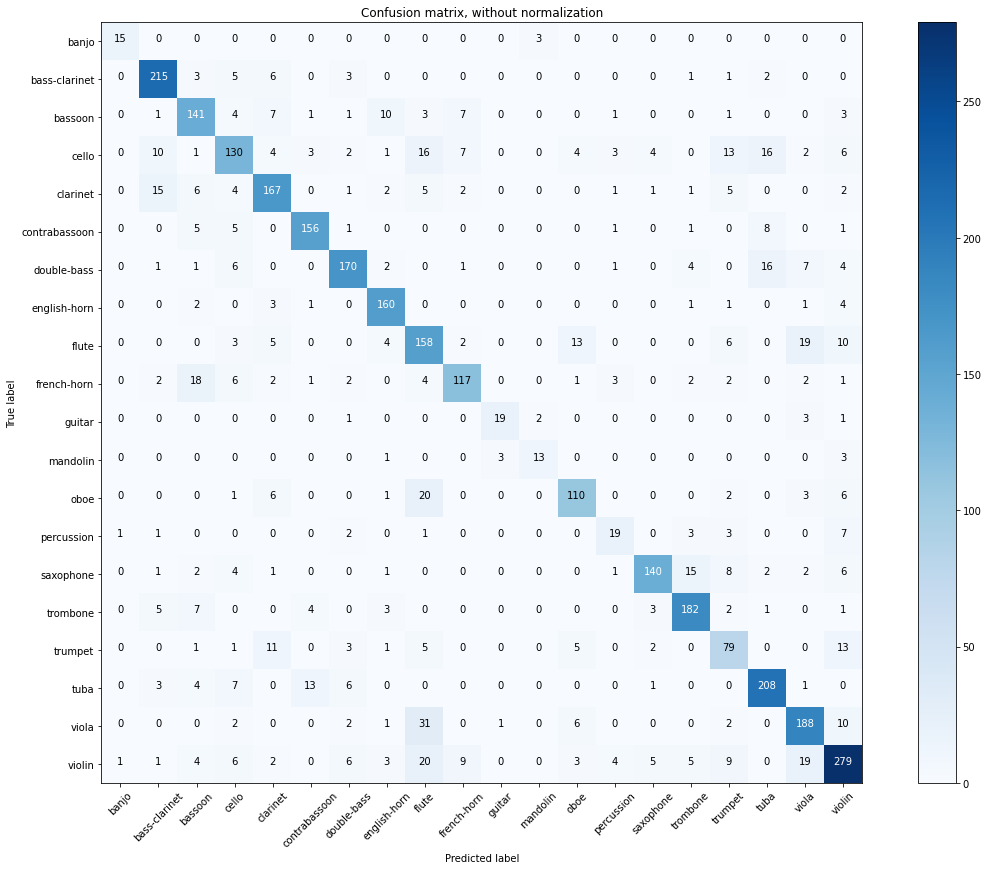

In [86]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Playback of 1st random Audio Files**

In [ ]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [ ]:
# Test
test_encoded, test_output, test_type = autoencoder(audio_to_test.to(device))
print('Original Shape', audio_to_test.shape)
print('Encoded Shape', test_encoded.shape)
print('Decoded Shape', test_output.shape)
print('Predicted Class', np.argmax(test_type.detach().cpu().numpy()))
print('Correct Class', np.argmax(label_to_test.detach().cpu().numpy()))
print('MSE', mean_squared_error(audio_to_test[0,0,:], test_output[0,0,:audio_to_test.shape[-1]].detach().cpu()))

Original Shape torch.Size([1, 1, 33408])
Encoded Shape torch.Size([1, 1024, 33])
Decoded Shape torch.Size([1, 1, 34814])
Predicted Class 9
Correct Class 3
MSE 1.2217686e-05


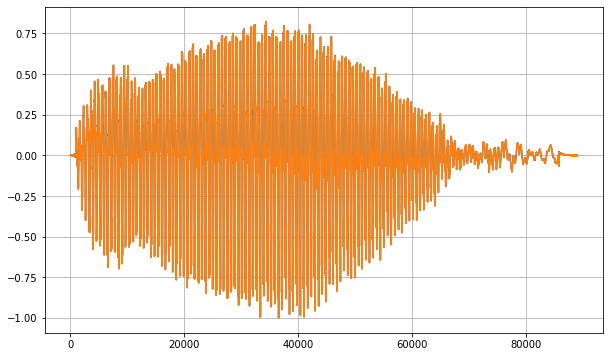

In [ ]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.plot(test_output[0,0,:].detach().cpu().numpy())
plt.grid()

In [ ]:
print("Model Output")
display(ipd.Audio(test_output[0,0,:].detach().cpu().numpy(), rate=44100))
print("Model Input")
display(ipd.Audio(audio_to_test[0,0,:], rate=44100))

Model Output


Model Input


In [ ]:
original_audio_specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

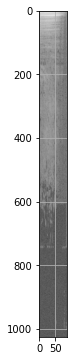

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(20*original_audio_specgram.log10().numpy(), cmap='gray')
plt.grid()

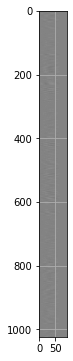

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(test_encoded[0,:,:].detach().cpu().numpy(), cmap='gray')
plt.grid()

In [ ]:
specgram_decoded_audio = torchaudio.transforms.Spectrogram(n_fft=2048)(test_output[0,0,:].to('cpu'))

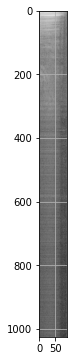

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(20*specgram_decoded_audio.log10().detach().numpy(), cmap='gray')
plt.grid()

# **Playback of 2nd random Audio File**

In [ ]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [ ]:
# Test
test_encoded, test_output, test_type = autoencoder(audio_to_test.to(device))
print('Original Shape', audio_to_test.shape)
print('Encoded Shape', test_encoded.shape)
print('Decoded Shape', test_output.shape)
print('Predicted Class', np.argmax(test_type.detach().cpu().numpy()))
print('Correct Class', np.argmax(label_to_test.detach().cpu().numpy()))
print('MSE', mean_squared_error(audio_to_test[0,0,:], test_output[0,0,:audio_to_test.shape[-1]].detach().cpu()))

Original Shape torch.Size([1, 1, 101376])
Encoded Shape torch.Size([1, 1024, 100])
Decoded Shape torch.Size([1, 1, 103422])
Predicted Class 5
Correct Class 5
MSE 2.2062986e-06


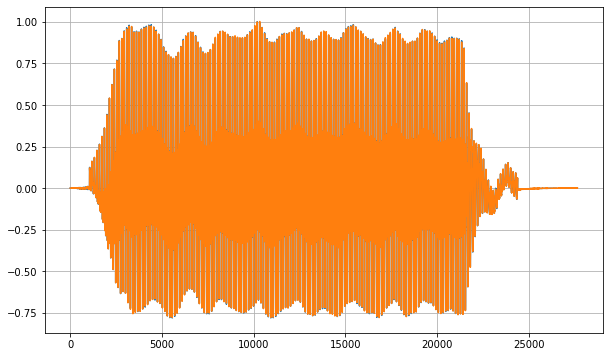

In [ ]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.plot(test_output[0,0,:].detach().cpu().numpy())
plt.grid()

In [ ]:
print("Model Output")
display(ipd.Audio(test_output[0,0,:].detach().cpu().numpy(), rate=44100))
print("Model Input")
display(ipd.Audio(audio_to_test[0,0,:], rate=44100))

Model Output


Model Input


# **Playback of 3rd random Audio File**

In [ ]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [ ]:
# Test
test_encoded, test_output, test_type = autoencoder(audio_to_test.to(device))
print('Original Shape', audio_to_test.shape)
print('Encoded Shape', test_encoded.shape)
print('Decoded Shape', test_output.shape)
print('Predicted Class', np.argmax(test_type.detach().cpu().numpy()))
print('Correct Class', np.argmax(label_to_test.detach().cpu().numpy()))
print('MSE', mean_squared_error(audio_to_test[0,0,:], test_output[0,0,:audio_to_test.shape[-1]].detach().cpu()))

Original Shape torch.Size([1, 1, 47232])
Encoded Shape torch.Size([1, 1024, 47])
Decoded Shape torch.Size([1, 1, 49150])
Predicted Class 12
Correct Class 12
MSE 1.661249e-05


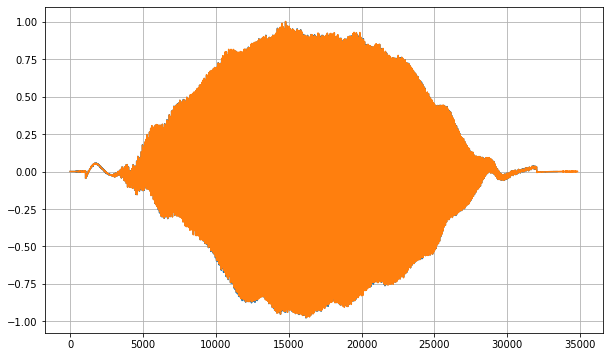

In [ ]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.plot(test_output[0,0,:].detach().cpu().numpy())
plt.grid()

In [ ]:
print("Model Output")
display(ipd.Audio(test_output[0,0,:].detach().cpu().numpy(), rate=44100))
print("Model Input")
display(ipd.Audio(audio_to_test[0,0,:], rate=44100))

Model Output


Model Input
